# Time Series Forecasting with XGBoost
Advanced Demand Forecasting with Recursive and Ensemble Methods

In [34]:
!pip install skforecast

In [223]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import time
from datetime import datetime
from skforecast.recursive._forecaster_recursive import ForecasterRecursive

## Data Loading
### Load and Clean the Dataset

In [224]:
# Load the historical demand dataset
df = pd.read_csv(r"D:\studies\s8\data science\pythonProject\historic_demand_2009_2024.csv", index_col=0)

# Print basic information about the loaded dataset
print("Original dataset shape:", df.shape)
print("Column names:", df.columns.tolist())

# Remove columns with null values
# Note: These columns contain values that started appearing after a specific year
# and might be useful in future analyses
df.drop(columns=["nsl_flow", "eleclink_flow", "scottish_transfer", "viking_flow", "greenlink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48 (data quality issue)
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

# Select only the columns we need for this analysis
df = df[['settlement_date', 'settlement_period', 'tsd', 'is_holiday']]

# Remove days with zero demand (likely data quality issues)
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()
null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

# Display the cleaned dataset
print("\nCleaned dataset shape:", df.shape)
print("First 5 rows of cleaned data:")
print(df.head())
print("\nData summary statistics:")
print(df.describe())

Original dataset shape: (279264, 23)
Column names: ['settlement_date', 'settlement_period', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer', 'viking_flow', 'greenlink_flow', 'is_holiday']

Cleaned dataset shape: (278512, 4)
First 5 rows of cleaned data:
  settlement_date  settlement_period    tsd  is_holiday
0      2009-01-01                  1  38704           1
1      2009-01-01                  2  38964           1
2      2009-01-01                  3  38651           1
3      2009-01-01                  4  37775           1
4      2009-01-01                  5  37298           1

Data summary statistics:
       settlement_period            tsd     is_holiday
count      278512.000000  278512.000000  278512.000000
m

## Feature Engineering
### Create Date-Time Features

In [225]:
def add_datepart(df):
    """
    Create comprehensive datetime features from the settlement date and period.

    Args:
        df (DataFrame): DataFrame containing settlement_date and settlement_period columns

    Returns:
        DataFrame: DataFrame with added datetime features
    """
    # Convert 'settlement_date' to datetime (ensure it's in the correct format)
    df["settlement_date"] = pd.to_datetime(df["settlement_date"])

    # Ensure that 'settlement_period' is an integer and calculate the period offset in minutes
    df["period_offset"] = pd.to_timedelta((df["settlement_period"] - 1) * 30, unit="m")

    # Add the period offset (Timedelta) to the settlement_date (Datetime) to get the timestamp
    df["timestamp"] = df["settlement_date"] + df["period_offset"]

    # Ensure 'timestamp' is in datetime format (in case it's not already)
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Create time-related features from timestamp
    df["day_of_week"] = df["timestamp"].dt.dayofweek  # Monday=0, Sunday=6
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    df["month"] = df["timestamp"].dt.month
    df["quarter"] = df["timestamp"].dt.quarter
    df["is_month_end"] = df["timestamp"].dt.is_month_end.astype(int)
    df["is_month_start"] = df["timestamp"].dt.is_month_start.astype(int)
    df["is_quarter_end"] = df["timestamp"].dt.is_quarter_end.astype(int)
    df["is_quarter_start"] = df["timestamp"].dt.is_quarter_start.astype(int)
    df["is_year_end"] = df["timestamp"].dt.is_year_end.astype(int)
    df["is_year_start"] = df["timestamp"].dt.is_year_start.astype(int)
    df["day_of_year"] = df["timestamp"].dt.dayofyear
    df["week_of_year"] = df["timestamp"].dt.isocalendar().week.astype(int)
    df["hour"] = df["timestamp"].dt.hour
    df["minute"] = df["timestamp"].dt.minute
    return df


In [226]:

# Apply the datetime feature engineering function
print("Adding datetime features...")
df = add_datepart(df)

# Clean up and set the timestamp as index
df.drop(columns=["period_offset", "settlement_date"], inplace=True)
df.set_index("timestamp", inplace=True)
df.sort_index(inplace=True)

# Show the dataframe with new features
print("\nDataset with datetime features:")
print(df.head())
print(f"Number of features: {df.shape[1]}")

Adding datetime features...

Dataset with datetime features:
                     settlement_period    tsd  is_holiday  day_of_week  \
timestamp                                                                
2009-01-01 00:00:00                  1  38704           1            3   
2009-01-01 00:30:00                  2  38964           1            3   
2009-01-01 01:00:00                  3  38651           1            3   
2009-01-01 01:30:00                  4  37775           1            3   
2009-01-01 02:00:00                  5  37298           1            3   

                     is_weekend  month  quarter  is_month_end  is_month_start  \
timestamp                                                                       
2009-01-01 00:00:00           0      1        1             0               1   
2009-01-01 00:30:00           0      1        1             0               1   
2009-01-01 01:00:00           0      1        1             0               1   
2009-01-01 01:3


## Data Exploration and Visualization
Examine Dataset Correlations and Patterns

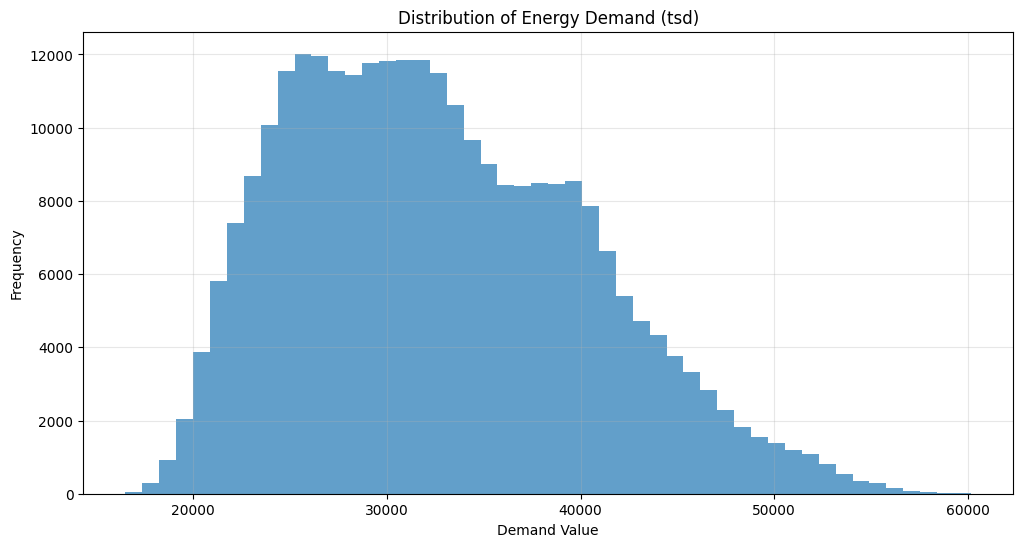

Generating correlation matrix heatmap...


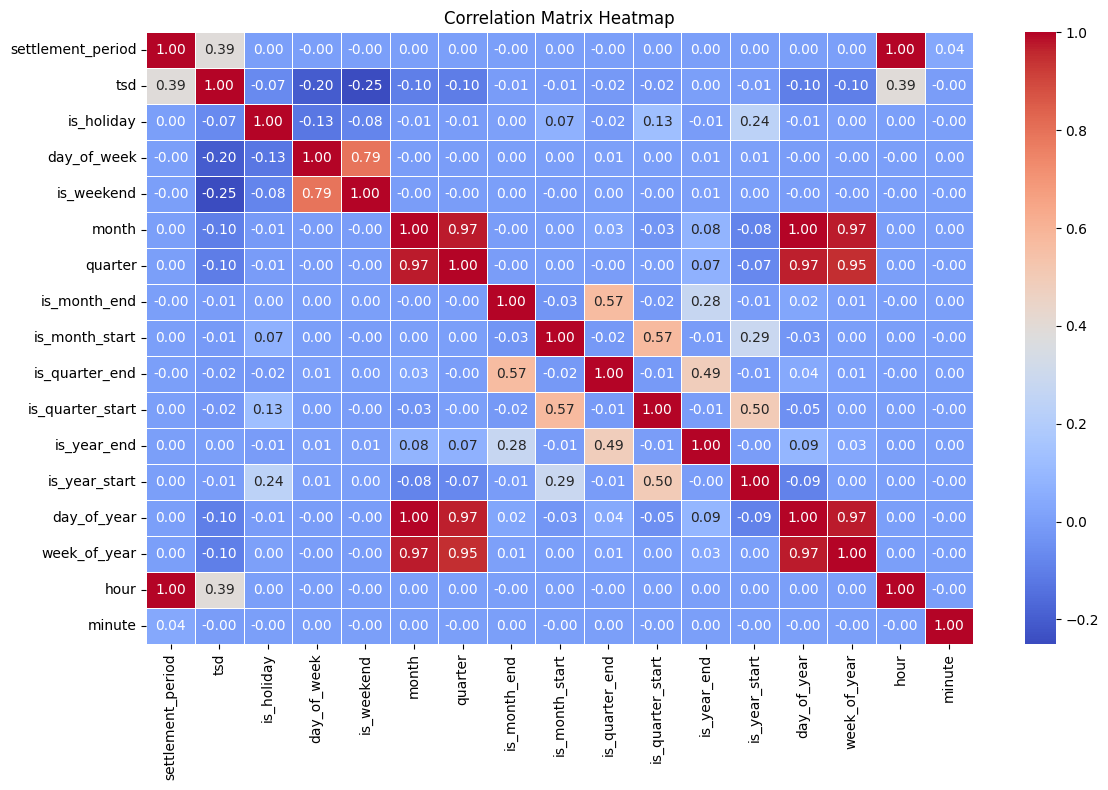

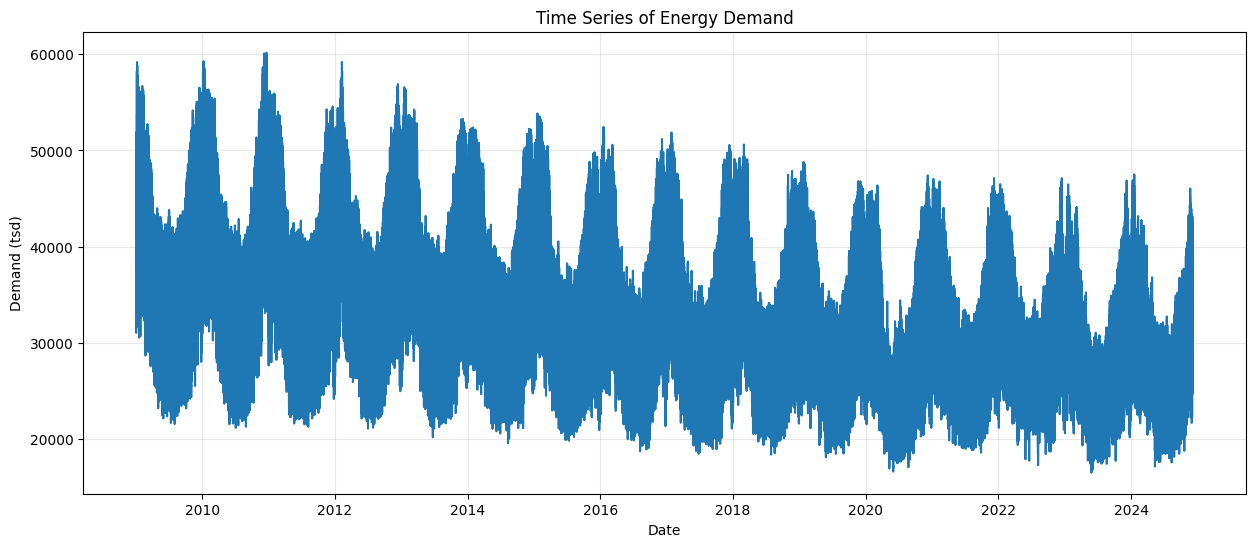

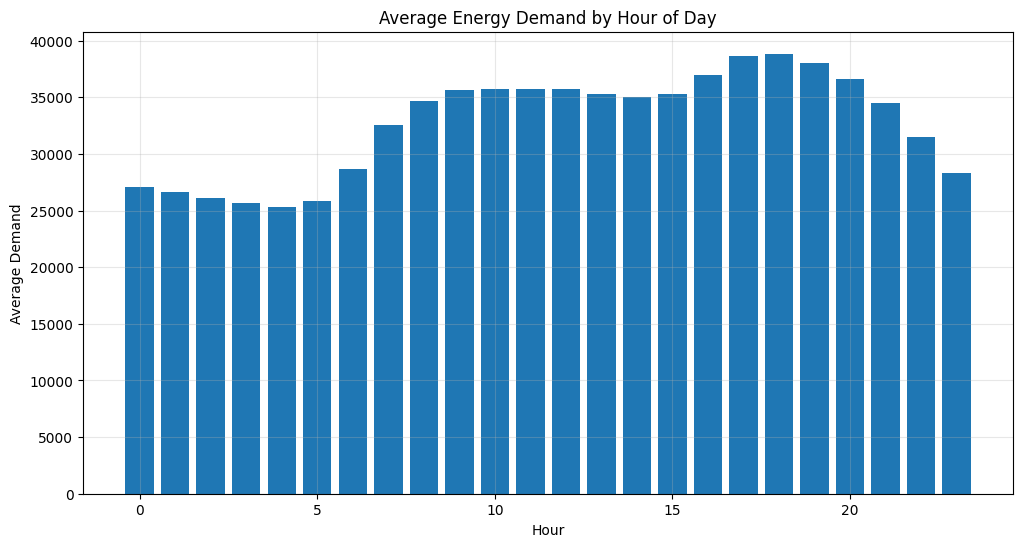

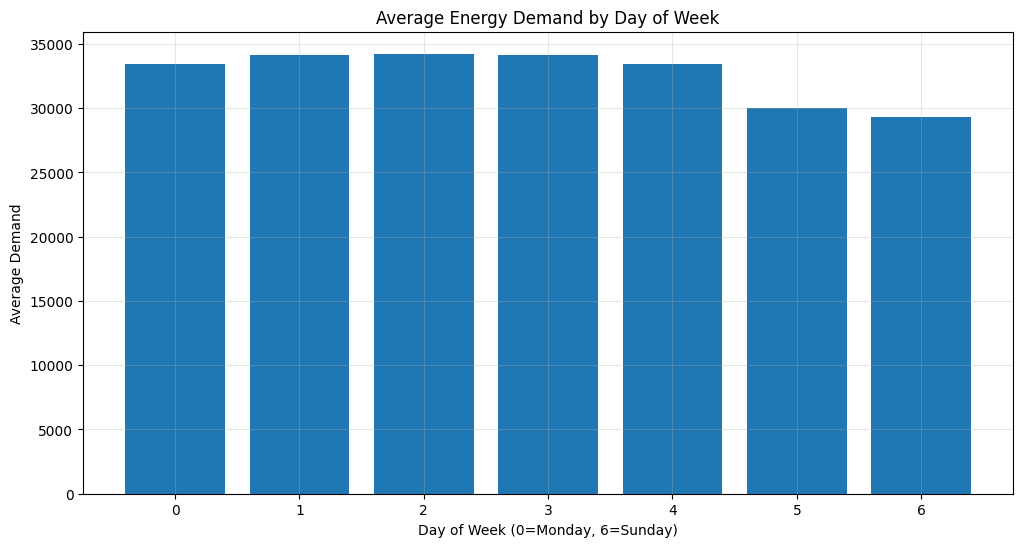

In [227]:

# Plot the distribution of the target variable (tsd)
plt.figure(figsize=(12, 6))
plt.hist(df['tsd'], bins=50, alpha=0.7)
plt.title('Distribution of Energy Demand (tsd)')
plt.xlabel('Demand Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Display correlation matrix heatmap
print("Generating correlation matrix heatmap...")
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

# Plot time series of the target variable
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['tsd'])
plt.title('Time Series of Energy Demand')
plt.xlabel('Date')
plt.ylabel('Demand (tsd)')
plt.grid(True, alpha=0.3)
plt.show()

# Examine patterns by hour of day
hourly_avg = df.groupby(df.index.hour)['tsd'].mean()
plt.figure(figsize=(12, 6))
plt.bar(hourly_avg.index, hourly_avg.values)
plt.title('Average Energy Demand by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Demand')
plt.grid(True, alpha=0.3)
plt.show()

# Examine patterns by day of week
daily_avg = df.groupby('day_of_week')['tsd'].mean()
plt.figure(figsize=(12, 6))
plt.bar(daily_avg.index, daily_avg.values)
plt.title('Average Energy Demand by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Demand')
plt.grid(True, alpha=0.3)
plt.show()


Create Features for Forecasting

In [228]:

def create_features(df, target_col, lag_periods=48, forecast_horizon=48):
    """
    Create lag features for time series forecasting.

    Args:
        df (DataFrame): Dataframe containing time series data
        target_col (str): Target column to create lags for
        lag_periods (int): Number of lag periods to create
        forecast_horizon (int): Number of periods ahead to forecast

    Returns:
        tuple: (X, y) Feature dataframe and target series
    """
    # Create a copy of the dataframe to avoid modifying the original
    data = df.copy()

    # Create lag features
    for lag in range(1, lag_periods + 1):
        data[f'lag_{lag}'] = data[target_col].shift(lag)

    # Create the target variable (forecast_horizon steps ahead)
    data['target'] = data[target_col].shift(-forecast_horizon)

    # Drop NaN values that result from shifting
    data = data.dropna()

    # Separate features and target
    y = data['target']
    X = data.drop('target', axis=1)

    return X, y

## Prepare Data for Training

In [229]:

def train_test_split_ts(X, y, test_size=0.2):
    """
    Split time series data chronologically into train and test sets.

    Args:
        X (DataFrame): Feature dataframe
        y (Series): Target series
        test_size (float): Fraction of data to use for testing

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    return X_train, X_test, y_train, y_test


In [ ]:

# def select_important_features(X_train, y_train, X_test, feature_importance_threshold=0.01):
#     """
#     Select important features based on a preliminary XGBoost model's feature importance

#     Args:
#         X_train: Training features
#         y_train: Training targets
#         X_test: Test features
#         feature_importance_threshold: Minimum importance threshold to keep a feature

#     Returns:
#         X_train_selected: Training features with only important features
#         X_test_selected: Test features with only important features
#         important_features: List of important feature names
#     """
#     print("\nPerforming feature selection...")

#     # Train a preliminary model to get feature importances
#     prelim_model = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=100,
#         learning_rate=0.1,
#         max_depth=5,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         random_state=42
#     )

#     prelim_model.fit(X_train, y_train)

#     # Get feature importances
#     importances = prelim_model.feature_importances_
#     feature_importance = pd.DataFrame({
#         'feature': X_train.columns,
#         'importance': importances
#     }).sort_values('importance', ascending=False)

#     # Normalize importances
#     total_importance = feature_importance['importance'].sum()
#     feature_importance['importance'] = feature_importance['importance'] / total_importance

#     # Select features above threshold
#     important_features = feature_importance[
#         feature_importance['importance'] >= feature_importance_threshold
#     ]['feature'].tolist()

#     print(f"Selected {len(important_features)} out of {X_train.shape[1]} features.")

#     # Select only important features
#     X_train_selected = X_train[important_features]
#     X_test_selected = X_test[important_features]

#     # Show top features
#     top_n = min(15, len(important_features))
#     print(f"\nTop {top_n} most important features:")
#     for i, (feature, importance) in enumerate(
#         zip(
#             feature_importance['feature'].values[:top_n],
#             feature_importance['importance'].values[:top_n]
#         )
#     ):
#         print(f"{i+1}. {feature}: {importance:.4f}")

#     # Plot top 20 feature importances
#     plt.figure(figsize=(12, 8))
#     plt.barh(feature_importance['feature'].values[:20],
#              feature_importance['importance'].values[:20])
#     plt.title('Top 20 Feature Importances')
#     plt.xlabel('Normalized Importance')
#     plt.gca().invert_yaxis()  # Display highest importance at the top
#     plt.show()

#     return X_train_selected, X_test_selected, important_features

In [231]:
def walk_forward_validation(X, y, forecast_horizon=48, n_windows=3):
    """
    Create multiple train/test splits using walk-forward validation.
    
    Args:
        X (DataFrame): Feature dataframe
        y (Series): Target series
        forecast_horizon (int): Number of periods to forecast
        n_windows (int): Number of validation windows
        
    Returns:
        list: List of (X_train, X_test, y_train, y_test) tuples
    """
    splits = []
    total_samples = len(X)
    
    # Reserve at least n_windows * forecast_horizon samples at the end
    reserved_samples = n_windows * forecast_horizon
    max_train_idx = total_samples - reserved_samples
    
    for i in range(n_windows):
        # Calculate end of training set for this window
        train_end_idx = max_train_idx + (i * forecast_horizon)
        # Test set is exactly forecast_horizon samples
        test_end_idx = train_end_idx + forecast_horizon
        
        # Create the split
        X_train, X_test = X.iloc[:train_end_idx], X.iloc[train_end_idx:test_end_idx]
        y_train, y_test = y.iloc[:train_end_idx], y.iloc[train_end_idx:test_end_idx]
        
        splits.append((X_train, X_test, y_train, y_test))
    
    return splits

In [251]:
def walk_forward_validation(X, y, forecast_horizon=48, n_windows=3, random_selection=True, random_seed=42):
    """
    Create multiple train/test splits using walk-forward validation with optional randomization.
    
    Args:
        X (DataFrame): Feature dataframe
        y (Series): Target series
        forecast_horizon (int): Number of periods to forecast
        n_windows (int): Number of validation windows
        random_selection (bool): Whether to randomly select start points for validation windows
        random_seed (int): Random seed for reproducibility
        
    Returns:
        list: List of (X_train, X_test, y_train, y_test) tuples
    """
    splits = []
    total_samples = len(X)
    
    # Ensure we have enough data for n_windows
    if total_samples < (n_windows * forecast_horizon):
        raise ValueError(f"Not enough data for {n_windows} windows of size {forecast_horizon}")
    
    # Calculate the valid range for starting test windows
    min_train_size = forecast_horizon * 2  # Ensure at least 2x forecast_horizon for training
    max_start_idx = total_samples - forecast_horizon
    
    if random_selection:
        # Set random seed for reproducibility
        np.random.seed(random_seed)
        
        # Generate random starting points, ensuring they're at least forecast_horizon apart
        # and leaving enough initial data for training
        possible_starts = list(range(min_train_size, max_start_idx))
        
        # If we have fewer possible starting points than windows, reduce the number of windows
        if len(possible_starts) < n_windows:
            n_windows = len(possible_starts)
            print(f"Warning: Reduced to {n_windows} windows due to data constraints")
        
        window_starts = []
        for _ in range(n_windows):
            if not possible_starts:
                break
                
            # Select random start point
            start = np.random.choice(possible_starts)
            window_starts.append(start)
            
            # Remove nearby points to prevent overlapping test windows
            # (remove any point within forecast_horizon of the selected start)
            possible_starts = [p for p in possible_starts 
                               if abs(p - start) > forecast_horizon]
        
        # Sort window starts to maintain chronological order in results
        window_starts.sort()
        
    else:
        # Original evenly-spaced windows logic
        reserved_samples = n_windows * forecast_horizon
        max_train_idx = total_samples - reserved_samples
        
        window_starts = [max_train_idx + (i * forecast_horizon) for i in range(n_windows)]
    
    # Create the splits based on window start points
    for start_idx in window_starts:
        end_idx = start_idx + forecast_horizon
        
        # Create the split
        X_train, X_test = X.iloc[:start_idx], X.iloc[start_idx:end_idx]
        y_train, y_test = y.iloc[:start_idx], y.iloc[start_idx:end_idx]
        
        splits.append((X_train, X_test, y_train, y_test))
    
    print(f"Created {len(splits)} validation windows with forecast horizon of {forecast_horizon}")
    
    return splits

Model Training functions

In [ ]:

# class TrainingProgressCallback:
#     """
#     Custom callback to track and display XGBoost training progress.

#     This callback provides real-time monitoring of training progress,
#     displays metrics at regular intervals, and supports early stopping.
#     """
#     def __init__(self, start_time=None, early_stopping_rounds=None, print_interval=10):
#         self.start_time = start_time or time.time()
#         self.early_stopping_rounds = early_stopping_rounds
#         self.print_interval = print_interval
#         self.best_score = float('inf')
#         self.best_iteration = 0
#         self.current_rounds_no_improve = 0

#     def __call__(self, env):
#         """Called after each iteration"""
#         # Extract evaluation results
#         score = env.evaluation_result_list[1][1]  # Validation score
#         iteration = env.iteration

#         # Track early stopping
#         if score < self.best_score:
#             self.best_score = score
#             self.best_iteration = iteration
#             self.current_rounds_no_improve = 0
#         else:
#             self.current_rounds_no_improve += 1

#         # Print status on selected intervals or if it's the last iteration
#         if iteration % self.print_interval == 0 or (self.early_stopping_rounds and
#                                                   self.current_rounds_no_improve >= self.early_stopping_rounds):
#             elapsed_time = time.time() - self.start_time
#             remaining = "Unknown"

#             if iteration > 0:
#                 time_per_iter = elapsed_time / (iteration + 1)
#                 if self.early_stopping_rounds and self.current_rounds_no_improve < self.early_stopping_rounds:
#                     estimated_remaining = (env.end_iteration - iteration) * time_per_iter
#                     remaining = f"{estimated_remaining:.1f} sec"

#             print(f"[{datetime.now().strftime('%H:%M:%S')}] Iteration {iteration:4d} | "
#                   f"Train RMSE: {env.evaluation_result_list[0][1]:.4f} | "
#                   f"Valid RMSE: {score:.4f} | "
#                   f"Best: {self.best_score:.4f} @ {self.best_iteration} | "
#                   f"No improve: {self.current_rounds_no_improve}/{self.early_stopping_rounds or 'None'} | "
#                   f"Elapsed: {elapsed_time:.1f} sec | "
#                   f"Remaining: {remaining}")

#         # Stop if we've reached the stopping rounds
#         if self.early_stopping_rounds and self.current_rounds_no_improve >= self.early_stopping_rounds:
#             print(f"\nEarly stopping at iteration {iteration}. Best score: {self.best_score:.4f} at iteration {self.best_iteration}")
#             return True

#         return False

In [252]:

def recursive_forecast(model, X_test, steps=48):
    """
    Make recursive forecasts using an XGBoost model.

    This function makes multi-step forecasts by using each prediction as
    an input feature for the next prediction (recursive approach).

    Args:
        model (XGBRegressor): Trained XGBoost model
        X_test (DataFrame): Initial test data with lag features
        steps (int): Number of steps to forecast

    Returns:
        list: Forecasted values
    """
    # Make a copy of the test data to avoid modifying the original
    data = X_test.iloc[0:1].copy()

    # Array to store forecasts
    forecasts = []

    # Get the initial lag feature names
    lag_cols = [col for col in data.columns if 'lag_' in col]
    lag_cols.sort(key=lambda x: int(x.split('_')[1]))

    # Get the target column (will be used to update lag features)
    target_col = 'tsd'

    # Show progress bar for recursive forecasting
    print("\nMaking recursive forecasts...")

    # Make recursive predictions
    for i in range(steps):
        if i % 10 == 0 or i == steps - 1:
            print(f"Forecasting step {i+1}/{steps}...")

        # Make prediction for the current step
        pred = model.predict(data.iloc[-1:])
        forecasts.append(pred[0])

        # If we've reached the desired forecast horizon, stop
        if i == steps - 1:
            break

        # Prepare data for the next prediction by shifting lag features
        last_row = data.iloc[-1].copy()

        # Shift lag values
        for j in range(1, len(lag_cols)):
            last_row[lag_cols[j-1]] = last_row[lag_cols[j]]

        # The most recent lag gets the predicted value
        last_row[lag_cols[-1]] = last_row[target_col]

        # The target value becomes our prediction
        last_row[target_col] = pred[0]

        # Add the updated row to our data
        data = pd.concat([data, pd.DataFrame([last_row])], ignore_index=True)

    print("Recursive forecasting complete.")
    return forecasts

In [ ]:
# def forecaster(model, lag_periods, X_train, X_test, y_test, forecast_length, target_col, df):
#   """Run a complete SKForecast model training and prediction workflow.
  
#   Args:
#       model: The regressor model to use (e.g., XGBRegressor)
#       lag_periods: Number of lag periods to use
#       X_train: Training exogenous features
#       X_test: Test exogenous features 
#       y_test: Test target values
#       forecast_length: Number of steps to forecast
#       target_col: Target column name in the original dataframe
#       df: Original dataframe containing the target column
  
#   Returns:
#       Tuple containing (predictions, metrics)
#   """
#   # Start timing
#   skf_start_time = time.time()
#   print("\nTraining SKForecast ForecasterRecursive model...")

#   # Create the lag grid
#   lags_grid = list(range(1, lag_periods + 1))

#   # Initialize the forecaster
#   forecaster = ForecasterRecursive(
#       regressor=model,
#       lags=lags_grid
#   )

#   # Extract the training series and align with exogenous features
#   train_series = df[target_col].loc[X_train.index[0]:X_train.index[-1]]
  
#   # Make sure indices align perfectly
#   if len(train_series) != len(X_train):
#       print(f"Adjusting train_series length to match X_train: {len(train_series)} → {len(X_train)}")
#       train_series = train_series.loc[X_train.index]

#   # Fit the forecaster
#   forecaster.fit(y=train_series, exog=X_train)
#   skf_train_time = time.time() - skf_start_time
#   print(f"SKForecast training completed in {skf_train_time:.2f} seconds")

#   # Make predictions
#   print("\nMaking SKForecast predictions...")
#   skf_start_pred_time = time.time()
  
#   # Get the time indices for the forecast period
#   forecast_indices = y_test.index[:forecast_length]
  
#   # Get exogenous features for the forecast period
#   exog_forecast = X_test.loc[forecast_indices]
  
#   # Make predictions with exogenous variables
#   predictions = forecaster.predict(steps=forecast_length, exog=exog_forecast)
#   skf_pred_time = time.time() - skf_start_pred_time
#   print(f"SKForecast prediction completed in {skf_pred_time:.2f} seconds")

#   # Calculate metrics
#   actual = y_test.iloc[:forecast_length].values
#   skf_mae = mean_absolute_error(actual, predictions.values)
#   skf_mse = mean_squared_error(actual, predictions.values)
#   skf_rmse = np.sqrt(skf_mse)
#   skf_mape = mean_absolute_percentage_error(actual, predictions.values)

#   print(f"\nSKForecast Prediction Results:")
#   print(f"MAE: {skf_mae:.2f}")
#   print(f"RMSE: {skf_rmse:.2f}")
#   print(f"MAPE: {skf_mape:.2f}%")
  
#   # Return predictions and metrics
#   metrics = {
#       'mae': skf_mae,
#       'mse': skf_mse,
#       'rmse': skf_rmse,
#       'mape': skf_mape,
#       'train_time': skf_train_time,
#       'pred_time': skf_pred_time
#   }
  
#   return predictions, metrics

In [253]:

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error

    Args:
        y_true: True values
        y_pred: Predicted values

    Returns:
        MAPE value (percentage)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape


## Training

In [254]:

# Setting parameters for forecasting
TARGET_COL = 'tsd'
LAG_PERIODS = 48  # One day of lags
FORECAST_HORIZON = 48  # One day ahead forecast
TEST_SIZE = 0.2

In [255]:
# Create features with lag values
print("Creating lag features...")
X, y = create_features(df, TARGET_COL, LAG_PERIODS, FORECAST_HORIZON)
print(f"Feature shape: {X.shape}, Target shape: {y.shape}")

Creating lag features...
Feature shape: (278416, 65), Target shape: (278416,)


In [256]:
splits = walk_forward_validation(X, y, n_windows=10)

Created 10 validation windows with forecast horizon of 48


In [ ]:

# Initialize and train XGBoost model
# print("\nInitializing XGBoost model with the following parameters:")
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'random_state': 0
}

# for param, value in xgb_params.items():
#     print(f"  {param}: {value}")

print("\nTraining XGBoost model...")
xgb_model = xgb.XGBRegressor(**xgb_params)

# Start timing the training
training_start_time = time.time()

# Create callback for early stopping
# progress_callback = TrainingProgressCallback(start_time=training_start_time, early_stopping_rounds=50, print_interval=10)
results_log = {}

for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
    # Train-test split for the current window
    print(f"\nTraining on window number {i + 1}...")

    # Train the model
    xgb_model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )

    # Make predictions
    predictions = xgb_model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)

    results_log[i] = {'mes': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}

    # print(f"Window results - MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
# # Train the model
# xgb_model.fit(
#     X_train,
#     y_train,
#     eval_set=[(X_train, y_train), (X_test, y_test)],
#     verbose=True
# )

training_time = time.time() - training_start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

# Calculate average results across all windows
avg_mse = np.mean([result['mes'] for result in results_log.values()])
avg_rmse = np.mean([result['rmse'] for result in results_log.values()])
avg_mae = np.mean([result['mae'] for result in results_log.values()])
avg_mape = np.mean([result['mape'] for result in results_log.values()])
print("\nAverage Results Across All Windows:")
print(f"Average MSE: {avg_mse:.2f}")
print(f"Average RMSE: {avg_rmse:.2f}")
print(f"Average MAE: {avg_mae:.2f}")
print(f"Average MAPE: {avg_mape:.2f}%")


Training XGBoost model...

Training on window number 1...

Training on window number 2...

Training on window number 3...

Training on window number 4...

Training on window number 5...

Training on window number 6...

Training on window number 7...

Training on window number 8...

Training on window number 9...

Training on window number 10...


In [175]:

# Create features with lag values
print("Creating lag features...")
X, y = create_features(df, TARGET_COL, LAG_PERIODS, FORECAST_HORIZON)
print(f"Feature shape: {X.shape}, Target shape: {y.shape}")

# Split data chronologically into train and test sets
X_train, X_test, y_train, y_test = train_test_split_ts(X, y, TEST_SIZE)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Training period: {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing period: {X_test.index.min()} to {X_test.index.max()}")


Creating lag features...
Feature shape: (278416, 65), Target shape: (278416,)
Training set: (222732, 65), Test set: (55684, 65)
Training period: 2009-01-02 00:00:00 to 2021-10-01 18:30:00
Testing period: 2021-10-01 19:00:00 to 2024-12-04 23:30:00


In [176]:

# Initialize and train XGBoost model
print("\nInitializing XGBoost model with the following parameters:")
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'random_state': 0
}

for param, value in xgb_params.items():
    print(f"  {param}: {value}")

print("\nTraining XGBoost model...")
xgb_model = xgb.XGBRegressor(**xgb_params)

# Start timing the training
training_start_time = time.time()

# Create callback for early stopping
progress_callback = TrainingProgressCallback(start_time=training_start_time, early_stopping_rounds=50, print_interval=10)

# Train the model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

training_time = time.time() - training_start_time
print(f"\nTraining completed in {training_time:.2f} seconds")


Initializing XGBoost model with the following parameters:
  objective: reg:squarederror
  n_estimators: 500
  learning_rate: 0.05
  max_depth: 6
  min_child_weight: 1
  subsample: 0.8
  colsample_bytree: 0.8
  gamma: 0
  random_state: 0

Training XGBoost model...
[0]	validation_0-rmse:7334.71950	validation_1-rmse:7184.31193
[1]	validation_0-rmse:7023.25790	validation_1-rmse:6887.80996
[2]	validation_0-rmse:6703.70921	validation_1-rmse:6582.12157
[3]	validation_0-rmse:6422.94422	validation_1-rmse:6315.86555
[4]	validation_0-rmse:6131.06620	validation_1-rmse:6037.03190
[5]	validation_0-rmse:5854.72271	validation_1-rmse:5773.21311
[6]	validation_0-rmse:5621.93391	validation_1-rmse:5552.36633
[7]	validation_0-rmse:5373.37474	validation_1-rmse:5318.44294
[8]	validation_0-rmse:5141.21776	validation_1-rmse:5098.63577
[9]	validation_0-rmse:4918.69384	validation_1-rmse:4887.54986
[10]	validation_0-rmse:4708.08913	validation_1-rmse:4688.33791
[11]	validation_0-rmse:4523.58335	validation_1-rmse:

## Results

In [177]:
# Make predictions on test set
print("\nMaking direct predictions on test set...")
prediction_start_time = time.time()
y_pred = xgb_model.predict(X_test)
prediction_time = time.time() - prediction_start_time
print(f"Predictions completed in {prediction_time:.2f} seconds")

# Calculate and display performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"\nDirect Prediction Results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Average Direct Prediction MAPE: {mape:.2f}%")  # Added line showing direct prediction MAPE



Making direct predictions on test set...
Predictions completed in 0.16 seconds

Direct Prediction Results:
MAE: 1333.86
RMSE: 1763.45
MAPE: 4.79%
Average Direct Prediction MAPE: 4.79%


<Figure size 1200x600 with 0 Axes>

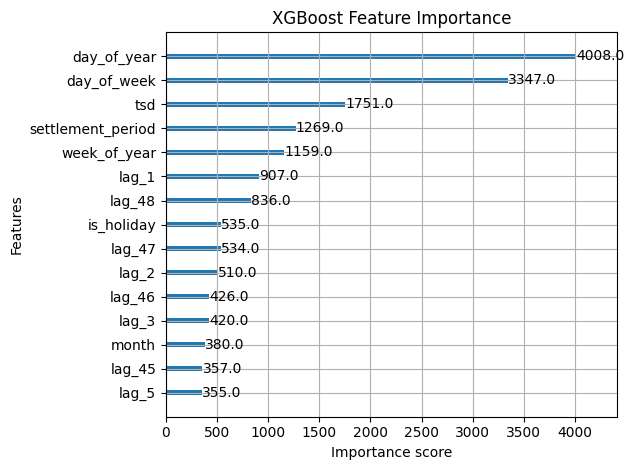


Top 10 Most Important Features:
              Feature  Importance
1                 tsd    0.407549
17              lag_1    0.367487
4          is_weekend    0.028243
3         day_of_week    0.027550
62             lag_46    0.022226
15               hour    0.015384
61             lag_45    0.009441
0   settlement_period    0.007259
63             lag_47    0.007083
2          is_holiday    0.007041


In [178]:

# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

# Create a DataFrame with feature importance values
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

## Recursive Forecasting

In [64]:
print("\nPerforming recursive forecasting...")
# Get a starting point from the test set
start_idx = 0
forecast_length = min(48, len(y_test))  # Forecast for up to 48 steps or the length of test set

# Get actual values for the forecast period
actual_values = y_test.iloc[start_idx:start_idx+forecast_length].values

# Get initial data for recursive forecasting
initial_data = X_test.iloc[start_idx:start_idx+1]

# Start timing recursive forecasting
recursive_start_time = time.time()

# Make recursive forecasts
recursive_preds = recursive_forecast(xgb_model, initial_data, steps=forecast_length)

recursive_time = time.time() - recursive_start_time
print(f"Recursive forecasting completed in {recursive_time:.2f} seconds")

# Calculate metrics for recursive forecasting
rec_mae = mean_absolute_error(actual_values, recursive_preds)
rec_mse = mean_squared_error(actual_values, recursive_preds)
rec_rmse = np.sqrt(rec_mse)
rec_mape = mean_absolute_percentage_error(actual_values, recursive_preds)

print(f"\nRecursive Prediction Results:")
print(f"MAE: {rec_mae:.2f}")
print(f"RMSE: {rec_rmse:.2f}")
print(f"MAPE: {rec_mape:.2f}%")
print(f"Average Recursive Prediction MAPE: {rec_mape:.2f}%")  # Added line showing recursive prediction MAPE


Performing recursive forecasting...

Making recursive forecasts...
Forecasting step 1/48...
Forecasting step 11/48...
Forecasting step 21/48...
Forecasting step 11/48...
Forecasting step 21/48...
Forecasting step 31/48...
Forecasting step 41/48...
Forecasting step 31/48...
Forecasting step 41/48...
Forecasting step 48/48...
Recursive forecasting complete.
Recursive forecasting completed in 0.93 seconds

Recursive Prediction Results:
MAE: 2929.83
RMSE: 3507.44
MAPE: 12.57%
Average Recursive Prediction MAPE: 12.57%
Forecasting step 48/48...
Recursive forecasting complete.
Recursive forecasting completed in 0.93 seconds

Recursive Prediction Results:
MAE: 2929.83
RMSE: 3507.44
MAPE: 12.57%
Average Recursive Prediction MAPE: 12.57%


In [189]:
# Initialize the SKForecast model
print("\nTraining SKForecast ForecasterRecursive model...")
skf_start_time = time.time()

# Create a new regressor with the same parameters
regressor = xgb.XGBRegressor(**xgb_params)
lags_grid = list(range(1, LAG_PERIODS + 1))

# Initialize the forecaster
forecaster = ForecasterRecursive(
    regressor=regressor,
    lags=lags_grid
)

# Extract the training series and align it with the exogenous features
train_series = df[TARGET_COL].loc[X_train.index[0]:X_train.index[-1]]

# Make sure the series is the same length as X_train
if len(train_series) != len(X_train):
    print(f"Adjusting train_series length to match X_train: {len(train_series)} → {len(X_train)}")
    train_series = train_series.loc[X_train.index]

print(f"Train series: {train_series.index.min()} to {train_series.index.max()} (n={len(train_series)})")
print(f"X_train: {X_train.index.min()} to {X_train.index.max()} (n={len(X_train)})")


Training SKForecast ForecasterRecursive model...
Train series: 2009-01-02 00:00:00 to 2021-10-01 18:30:00 (n=222732)
X_train: 2009-01-02 00:00:00 to 2021-10-01 18:30:00 (n=222732)


In [210]:
temp_df = df.resample("30t").sum()

C:\Users\ronsh\AppData\Local\Temp\ipykernel_172624\3453917376.py:1: FutureWarning: 't' is deprecated and will be removed in a future version, please use 'min' instead.
  temp_df = df.resample("30t").sum()


In [211]:
X_forecaster = temp_df.drop(columns=['tsd'])
y_forecaster = temp_df['tsd']

In [212]:
X_train_forecaster, X_test_forecaster, y_train_forecaster, y_test_forecaster = train_test_split_ts(X_forecaster, y_forecaster, TEST_SIZE)

In [213]:
forecaster.fit(y=y_train_forecaster, exog=X_train_forecaster)

In [214]:
# Calculate how many steps you need (48 half-hour periods = 2 days)
forecast_length = 48  # or however many periods you need

# Use integer for steps
preds = forecaster.predict(
    steps=forecast_length,
    exog=X_test_forecaster
)

In [221]:
preds

2021-09-29 09:30:00    29618.158203
2021-09-29 10:00:00    29386.769531
2021-09-29 10:30:00    29127.546875
2021-09-29 11:00:00    29013.675781
2021-09-29 11:30:00    28937.253906
2021-09-29 12:00:00    28896.833984
2021-09-29 12:30:00    28683.814453
2021-09-29 13:00:00    28567.814453
2021-09-29 13:30:00    28310.451172
2021-09-29 14:00:00    28330.707031
2021-09-29 14:30:00    28431.990234
2021-09-29 15:00:00    28870.539062
2021-09-29 15:30:00    29711.822266
2021-09-29 16:00:00    30871.726562
2021-09-29 16:30:00    32485.099609
2021-09-29 17:00:00    33824.640625
2021-09-29 17:30:00    34649.921875
2021-09-29 18:00:00    35263.371094
2021-09-29 18:30:00    35677.152344
2021-09-29 19:00:00    35870.082031
2021-09-29 19:30:00    35588.910156
2021-09-29 20:00:00    34887.023438
2021-09-29 20:30:00    33690.437500
2021-09-29 21:00:00    32343.798828
2021-09-29 21:30:00    30434.072266
2021-09-29 22:00:00    28645.068359
2021-09-29 22:30:00    26780.462891
2021-09-29 23:00:00    24907

In [217]:
y_test_forecaster

timestamp
2021-09-29 09:30:00    29087
2021-09-29 10:00:00    28285
2021-09-29 10:30:00    27591
2021-09-29 11:00:00    27254
2021-09-29 11:30:00    27163
                       ...  
2024-12-05 21:30:00    31431
2024-12-05 22:00:00    29846
2024-12-05 22:30:00    28805
2024-12-05 23:00:00    26825
2024-12-05 23:30:00    26133
Freq: 30min, Name: tsd, Length: 55853, dtype: int64

In [222]:
# Calculate and display performance metrics
mae = mean_absolute_error(y_test_forecaster[:48], preds)
mse = mean_squared_error(y_test_forecaster[:48], preds)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_forecaster[:48], preds)

print(f"\nDirect Prediction Results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Average Direct Prediction MAPE: {mape:.2f}%")  # Added line showing direct prediction MAPE


Direct Prediction Results:
MAE: 892.38
RMSE: 1091.62
MAPE: 3.16%
Average Direct Prediction MAPE: 3.16%


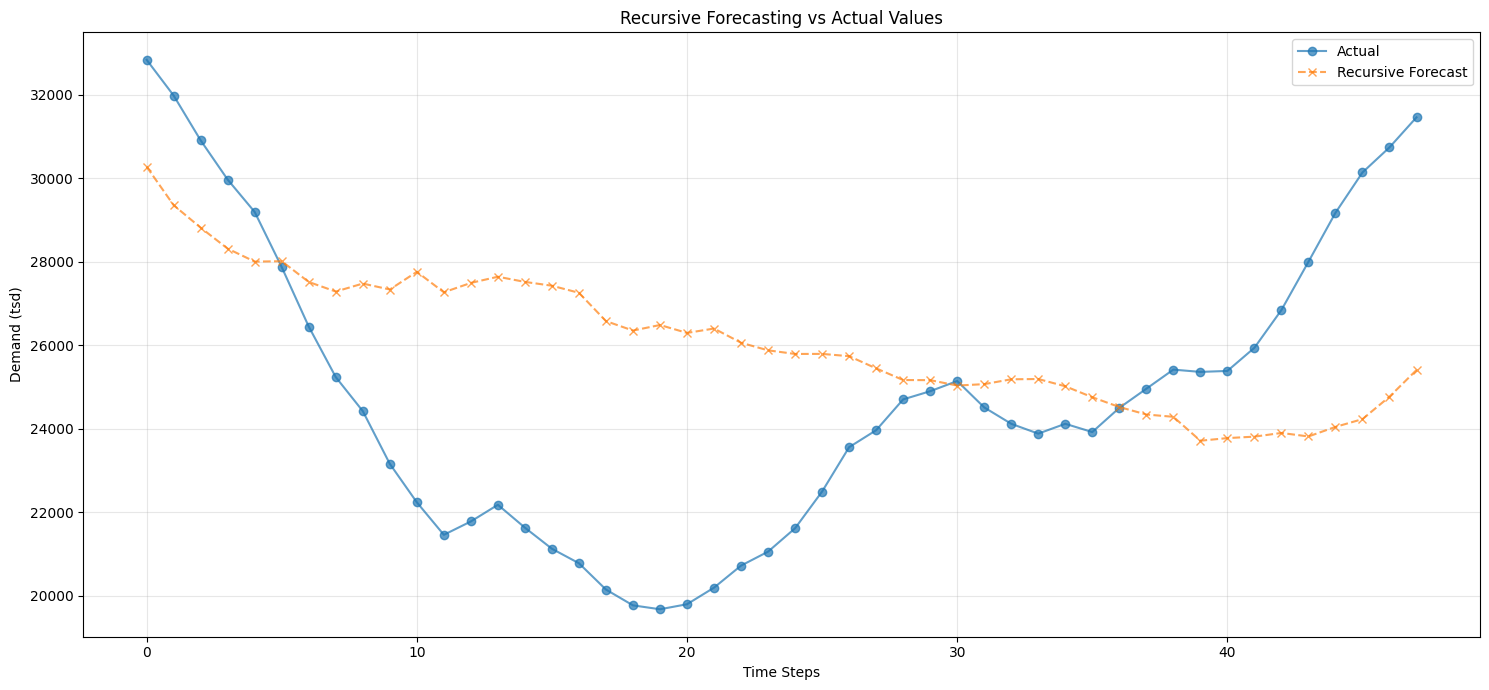

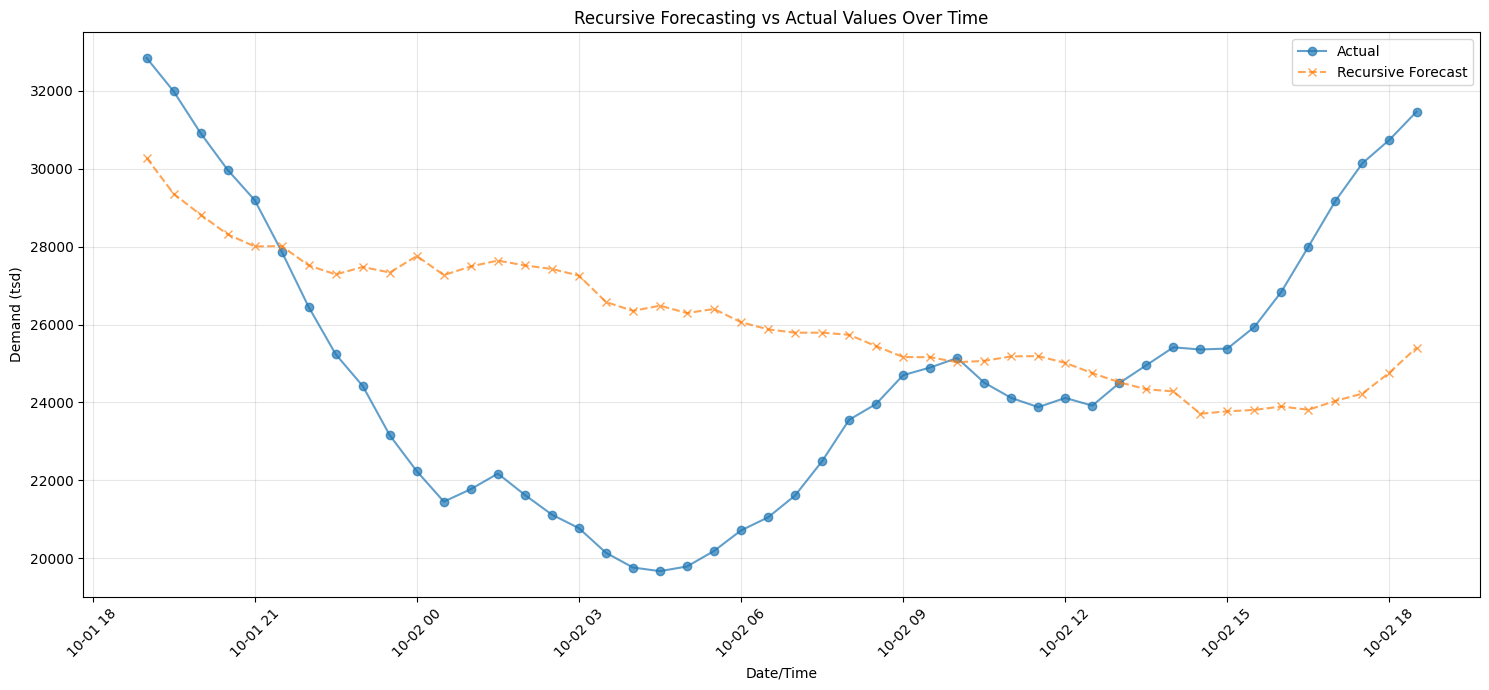

In [21]:
# Plot recursive forecasting results
plt.figure(figsize=(15, 7))
plt.plot(actual_values, label='Actual', marker='o', linestyle='-', alpha=0.7)
plt.plot(recursive_preds, label='Recursive Forecast', marker='x', linestyle='--', alpha=0.7)
plt.title('Recursive Forecasting vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Demand (tsd)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize predictions vs actual over time
plt.figure(figsize=(15, 7))
time_idx = y_test.index[start_idx:start_idx+forecast_length]
plt.plot(time_idx, actual_values, label='Actual', marker='o', linestyle='-', alpha=0.7)
plt.plot(time_idx, recursive_preds, label='Recursive Forecast', marker='x', linestyle='--', alpha=0.7)
plt.title('Recursive Forecasting vs Actual Values Over Time')
plt.xlabel('Date/Time')
plt.ylabel('Demand (tsd)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


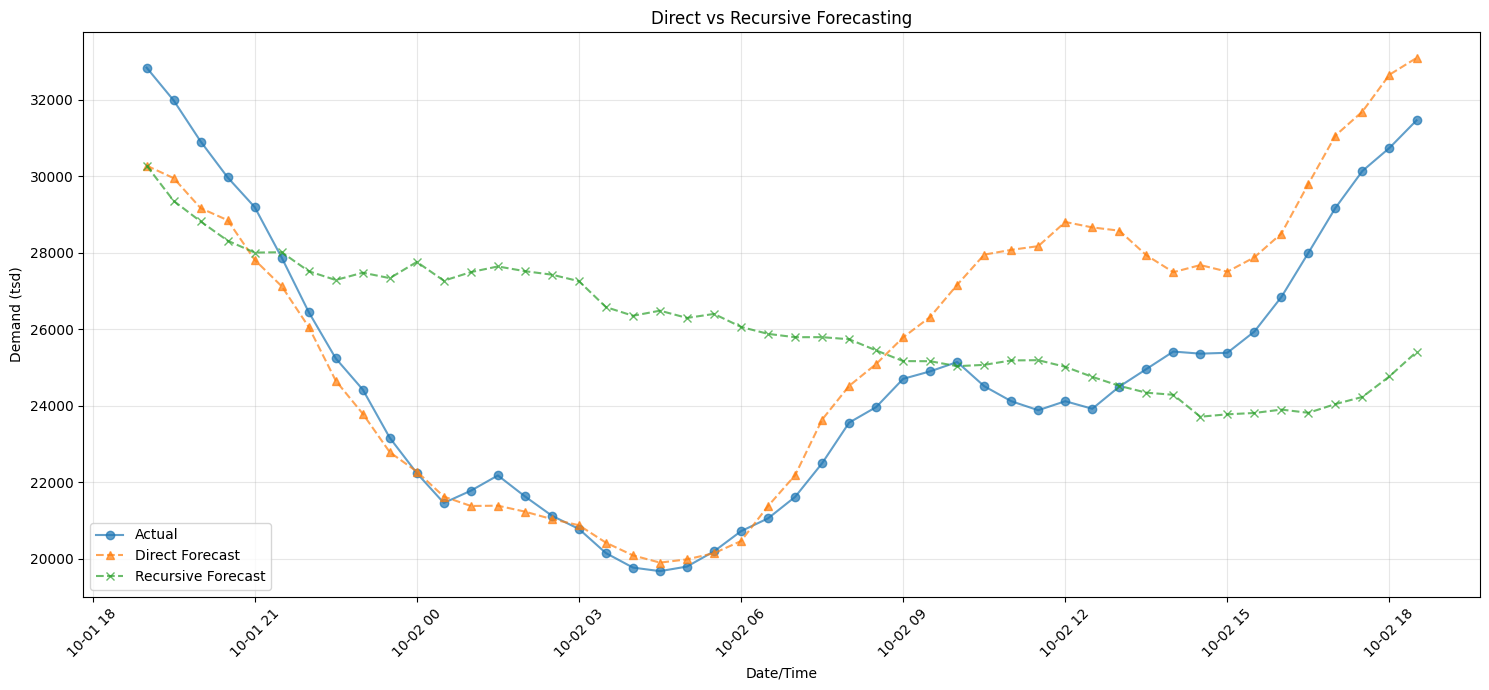


Comparison of Direct vs Recursive Forecasts (First 10 rows):
    Actual        Direct     Recursive
0  32843.0  30279.160156  30279.160156
1  31986.0  29952.402344  29356.732422
2  30911.0  29166.691406  28818.367188
3  29970.0  28851.140625  28315.431641
4  29194.0  27813.498047  28004.943359
5  27872.0  27122.757812  28014.439453
6  26447.0  26056.888672  27516.755859
7  25236.0  24652.490234  27287.212891
8  24421.0  23788.123047  27479.013672
9  23157.0  22782.089844  27336.300781


In [22]:
# Compare direct vs recursive forecasting
plt.figure(figsize=(15, 7))
direct_preds = y_pred[start_idx:start_idx+forecast_length]
plt.plot(time_idx, actual_values, label='Actual', marker='o', linestyle='-', alpha=0.7)
plt.plot(time_idx, direct_preds, label='Direct Forecast', marker='^', linestyle='--', alpha=0.7)
plt.plot(time_idx, recursive_preds, label='Recursive Forecast', marker='x', linestyle='--', alpha=0.7)
plt.title('Direct vs Recursive Forecasting')
plt.xlabel('Date/Time')
plt.ylabel('Demand (tsd)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a DataFrame to compare direct and recursive forecasts
comparison_df = pd.DataFrame({
    'Actual': actual_values,
    'Direct': direct_preds,
    'Recursive': recursive_preds
})
print("\nComparison of Direct vs Recursive Forecasts (First 10 rows):")
print(comparison_df.head(10))

In [23]:
# Cell 16: Multi-horizon Forecast Evaluation
# ## Evaluating Performance Across Different Horizons

def evaluate_multi_horizon(model, X_test, y_test, max_horizon=48):
    """
    Evaluate model performance across multiple forecast horizons.

    Args:
        model (XGBRegressor): Trained model
        X_test (DataFrame): Test features
        y_test (Series): Test targets
        max_horizon (int): Maximum forecast horizon to evaluate

    Returns:
        DataFrame: Performance metrics for each horizon
    """
    results = []

    print(f"\nEvaluating performance across forecast horizons (1 to {max_horizon})...")

    for horizon in range(1, max_horizon+1):
        if horizon % 10 == 0 or horizon == 1 or horizon == max_horizon:
            print(f"Evaluating horizon {horizon}/{max_horizon}...")

        # Make recursive forecasts for this horizon
        forecasts = []
        actuals = []

        # We need enough data in the test set to make a forecast for this horizon
        for i in range(len(X_test) - horizon):
            initial_data = X_test.iloc[i:i+1]
            forecast = recursive_forecast(model, initial_data, steps=horizon)
            forecasts.append(forecast[-1])  # We only care about the forecast at the target horizon
            actuals.append(y_test.iloc[i+horizon-1])

        # Calculate metrics
        if len(forecasts) > 0:
            mae = mean_absolute_error(actuals, forecasts)
            mse = mean_squared_error(actuals, forecasts)
            rmse = np.sqrt(mse)
            mape = mean_absolute_percentage_error(actuals, forecasts)

            results.append({
                'Horizon': horizon,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'Samples': len(forecasts)
            })

    return pd.DataFrame(results)

Streaming output truncated to the last 5000 lines.

Making recursive forecasts...
Forecasting step 1/9...
Forecasting step 9/9...
Recursive forecasting complete.

Making recursive forecasts...
Forecasting step 1/9...
Forecasting step 9/9...
Recursive forecasting complete.

Making recursive forecasts...
Forecasting step 1/9...
Forecasting step 9/9...
Recursive forecasting complete.

Making recursive forecasts...
Forecasting step 1/9...
Forecasting step 9/9...
Recursive forecasting complete.

Making recursive forecasts...
Forecasting step 1/9...
Forecasting step 9/9...
Recursive forecasting complete.

Making recursive forecasts...
Forecasting step 1/9...
Forecasting step 9/9...
Recursive forecasting complete.

Making recursive forecasts...
Forecasting step 1/9...
Forecasting step 9/9...
Recursive forecasting complete.

Making recursive forecasts...
Forecasting step 1/9...
Forecasting step 9/9...
Recursive forecasting complete.

Making recursive forecasts...
Forecasting step 1/9...
Foreca

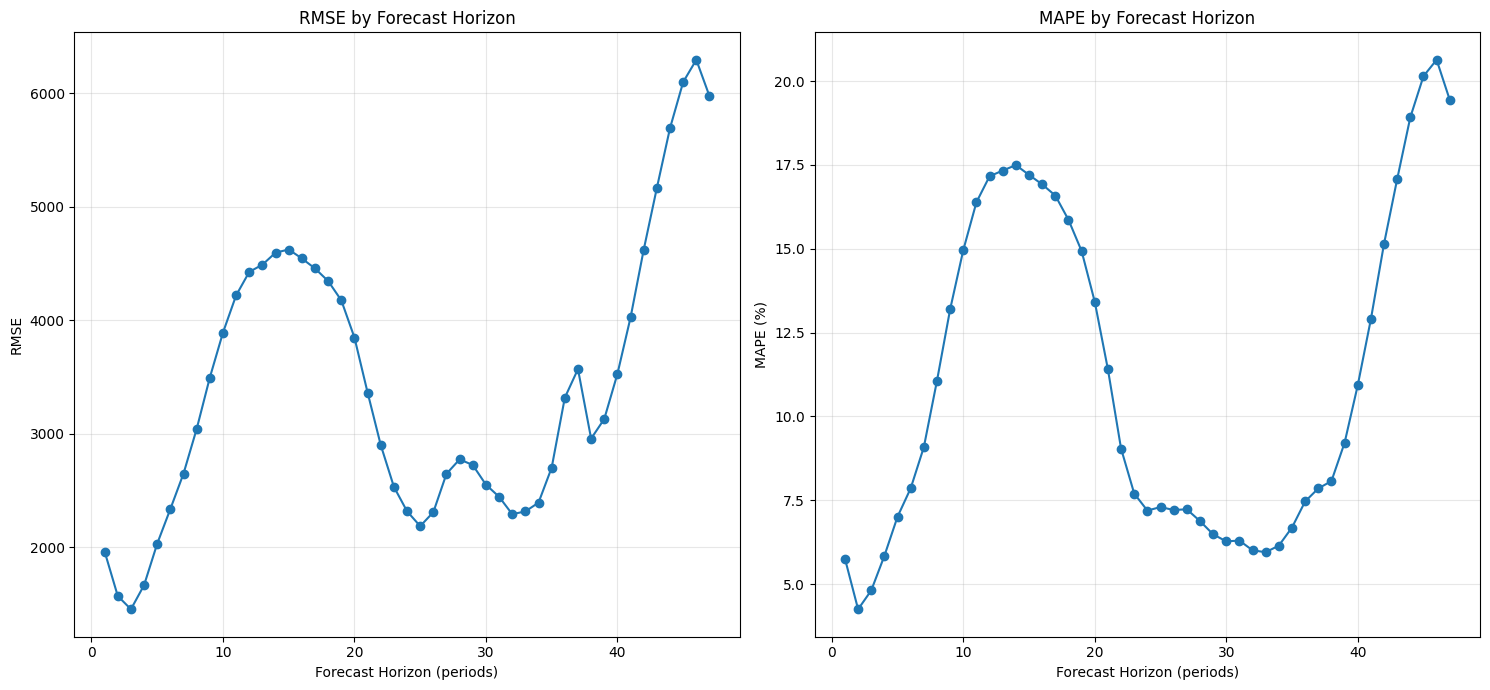

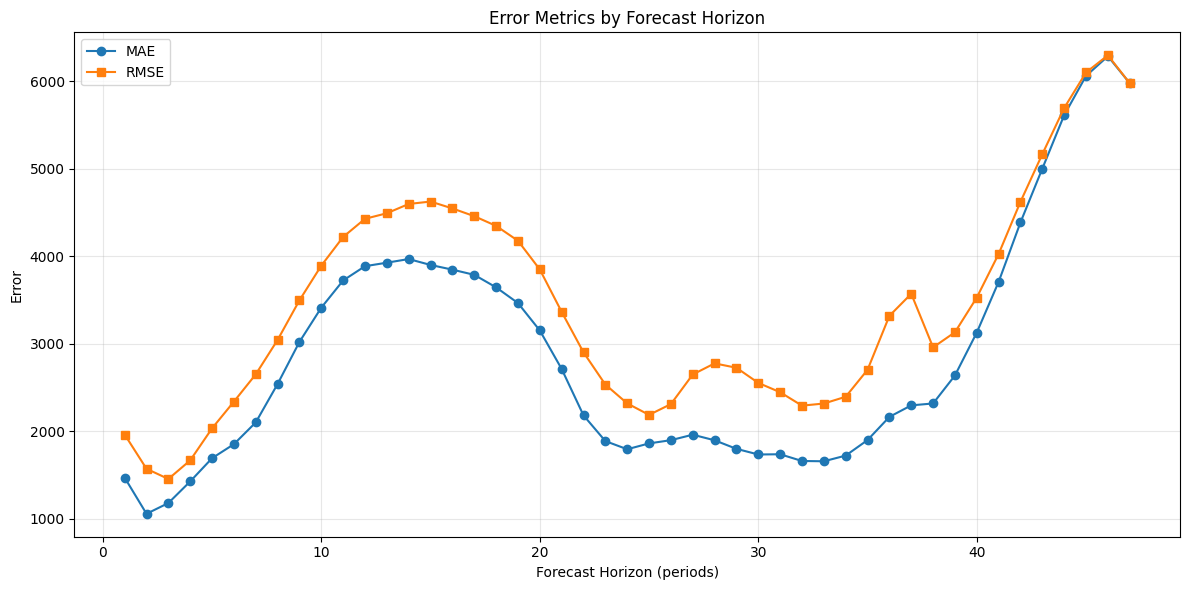

In [ ]:

# Evaluate performance across multiple horizons (limited to a few samples for speed)
print("\nEvaluating performance across forecast horizons...")
max_samples = min(48, len(X_test) - 48)  # Use at most 48 samples
horizon_results = evaluate_multi_horizon(xgb_model, X_test[:max_samples], y_test[:max_samples], max_horizon=48)

# Save the horizon results to a CSV file
horizon_results.to_csv('forecast_horizon_metrics.csv', index=False)
print("Saved horizon metrics to forecast_horizon_metrics.csv")

# Display summary of horizon results
print("\nSummary of forecast performance by horizon:")
print(f"Average MAPE across all horizons: {horizon_results['MAPE'].mean():.2f}%")
print(f"Best MAPE: {horizon_results['MAPE'].min():.2f}% at horizon {horizon_results.loc[horizon_results['MAPE'].idxmin(), 'Horizon']}")
print(f"Worst MAPE: {horizon_results['MAPE'].max():.2f}% at horizon {horizon_results.loc[horizon_results['MAPE'].idxmax(), 'Horizon']}")

# Cell 17: Visualizing Performance by Horizon
# ## Plotting Error Metrics Across Forecast Horizons

# Plot results by horizon
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(horizon_results['Horizon'], horizon_results['RMSE'], marker='o')
plt.title('RMSE by Forecast Horizon')
plt.xlabel('Forecast Horizon (periods)')
plt.ylabel('RMSE')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(horizon_results['Horizon'], horizon_results['MAPE'], marker='o')
plt.title('MAPE by Forecast Horizon')
plt.xlabel('Forecast Horizon (periods)')
plt.ylabel('MAPE (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot a more detailed view of horizon performance
plt.figure(figsize=(12, 6))
plt.plot(horizon_results['Horizon'], horizon_results['MAE'], marker='o', label='MAE')
plt.plot(horizon_results['Horizon'], horizon_results['RMSE'], marker='s', label='RMSE')
plt.title('Error Metrics by Forecast Horizon')
plt.xlabel('Forecast Horizon (periods)')
plt.ylabel('Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Save model for later use
model_filename = 'xgboost_recursive_forecast_model.json'
xgb_model.save_model(model_filename)
print(f"Model saved to {model_filename}")

# Save predictions for further analysis
results_df = pd.DataFrame({
    'timestamp': time_idx,
    'actual': actual_values,
    'direct_forecast': direct_preds,
    'recursive_forecast': recursive_preds,
    'skforecast': skf_preds.values,
    'simple_forecast': simple_preds.values
})
results_df.to_csv('forecast_results.csv')
print("Saved forecast results to forecast_results.csv")

# Performance Comparison and Conclusions

# Create a summary DataFrame for easy comparison
summary_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE (%)', 'Train Time (s)', 'Prediction Time (s)'],
    'Direct XGBoost': [mae, rmse, mape, training_time, prediction_time],
    'Custom Recursive': [rec_mae, rec_rmse, rec_mape, training_time, recursive_time],
    'SKForecast (48 lags)': [skf_mae, skf_rmse, skf_mape, skf_train_time, skf_pred_time],
    'SKForecast (5 lags)': [simple_mae, simple_rmse, simple_mape, simple_train_time, simple_pred_time]
})

# Final summary of performance metrics
print("\n=== FINAL PERFORMANCE SUMMARY ===")
print(f"Direct XGBoost MAPE: {mape:.2f}%")
print(f"Custom Recursive MAPE: {rec_mape:.2f}%")
print(f"SKForecast (48 lags) MAPE: {skf_mape:.2f}%")
print(f"SKForecast (5 lags) MAPE: {simple_mape:.2f}%")
print("==================================\n")

# Print detailed comparison table
print("Full Performance Comparison:")
print(summary_df)

# Create a comparison plot
plt.figure(figsize=(15, 7))
plt.plot(time_idx, actual_values, label='Actual', marker='o', linestyle='-', alpha=0.7)
plt.plot(time_idx, direct_preds, label=f'Direct XGBoost (MAPE: {mape:.2f}%)', marker='^', linestyle='--', alpha=0.7)
plt.plot(time_idx, recursive_preds, label=f'Custom Recursive (MAPE: {rec_mape:.2f}%)', marker='x', linestyle='--', alpha=0.7)
plt.plot(time_idx, skf_preds.values, label=f'SKForecast 48 lags (MAPE: {skf_mape:.2f}%)', marker='s', linestyle='--', alpha=0.7)
plt.plot(time_idx, simple_preds.values, label=f'SKForecast 5 lags (MAPE: {simple_mape:.2f}%)', marker='d', linestyle='--', alpha=0.7)
plt.title('Comparison of Forecasting Methods')
plt.xlabel('Date/Time')
plt.ylabel('Demand (tsd)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('forecast_methods_comparison.png')
plt.show()

print("\nXGBoost Recursive Forecasting Model Complete.")
print("This notebook demonstrates multiple forecasting approaches for time series data:")
print("1. Direct forecasting with XGBoost")
print("2. Custom recursive forecasting with XGBoost")
print("3. SKForecast with different lag configurations")
print("\nThe results highlight the trade-offs between these approaches and provide insights for model selection.")



Model saved to xgboost_recursive_forecast_model.json
Saved forecast results to forecast_results.csv

=== FINAL PERFORMANCE SUMMARY ===
Direct Prediction Average MAPE: 4.77%
Recursive Prediction Average MAPE: 14.19%
Difference: 9.43%
Percentage Improvement: 197.78%

Full Performance Comparison:
     Metric  Direct Forecasting  Recursive Forecasting   Difference
0       MAE         1328.893622            3303.808797  1974.915176
1      RMSE         1758.509350            4013.934408  2255.425058
2  MAPE (%)            4.766039              14.192262     9.426222

XGBoost Recursive Forecasting Model Complete.
This notebook demonstrates both direct and recursive forecasting approaches for time series data.
The results highlight the trade-offs between these approaches and provide insights for model selection.


In [ ]:
!pip install skforecast

In [ ]:
from skforecast.recursive._forecaster_recursive import ForecasterRecursive
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import time

# Set a smaller number of lags for the simpler model
n_lags = 5  # Reduced from 48 for faster training

# Define the Forecaster with XGBoost
simple_forecaster = ForecasterRecursive(
    regressor=XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    lags=n_lags
)

# Create a simplified training series
print("\nTraining a simplified SKForecast model with fewer lags...")
simple_start_time = time.time()

# Fit the forecaster on training data - specify index alignment and include it directly
train_series_simple = df[TARGET_COL].loc[X_train.index[0]:X_train.index[-1]]
train_series_simple = train_series_simple.loc[X_train.index]

# Fit the model with exogenous variables
simple_forecaster.fit(y=train_series_simple, exog=X_train)
simple_train_time = time.time() - simple_start_time
print(f"Simple forecaster training completed in {simple_train_time:.2f} seconds")

# Forecast settings
start_idx = 0
forecast_length = min(48, len(y_test))

# Get true values for forecast horizon
actual_values_simple = y_test.iloc[start_idx:start_idx + forecast_length].values

# Get the time indices for the forecast period
forecast_indices = y_test.index[start_idx:start_idx + forecast_length]

# Get exogenous variables for the forecast period
exog_forecast_simple = X_test.loc[forecast_indices]

# Start timing
simple_pred_time_start = time.time()

# Forecast with exogenous variables
simple_preds = simple_forecaster.predict(steps=forecast_length, exog=exog_forecast_simple)

simple_pred_time = time.time() - simple_pred_time_start
print(f"Simple forecasting completed in {simple_pred_time:.2f} seconds")

# Evaluation
simple_mae = mean_absolute_error(actual_values_simple, simple_preds.values)
simple_mse = mean_squared_error(actual_values_simple, simple_preds.values)
simple_rmse = np.sqrt(simple_mse)
simple_mape = mean_absolute_percentage_error(actual_values_simple, simple_preds.values)

print(f"\nSimple Recursive Prediction Results (ForecasterRecursive with 5 lags):")
print(f"MAE: {simple_mae:.2f}")
print(f"RMSE: {simple_rmse:.2f}")
print(f"MAPE: {simple_mape:.2f}%")

# Compare all forecasting methods
print("\n=== FORECASTING METHODS COMPARISON ===")
print(f"Direct XGBoost MAPE: {mape:.2f}%")
print(f"Custom Recursive XGBoost MAPE: {rec_mape:.2f}%")
print(f"SKForecast (48 lags) MAPE: {skf_mape:.2f}%")
print(f"SKForecast (5 lags) MAPE: {simple_mape:.2f}%")


╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has a pandas DatetimeIndex without a frequency. The index will be replaced by │
│ a RangeIndex starting from 0 with a step of 1. To avoid this warning, set the        │
│ frequency of the DatetimeIndex using `y = y.asfreq('desired_frequency',              │
│ fill_value=np.nan)`.                                                                 │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location : /usr/local/lib/python3.11/dist-packages/skforecast/utils/utils.py:1402    │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `last_window` has a pandas DatetimeIndex without a frequency. The index will be      │
│ replaced by a RangeIndex starting from 0 with a step of 1. To avoid this warning,    │
│ set the frequency of the DatetimeIndex using `last_window =                          │
│ last_window.asfreq('desired_frequency', fill_value=np.nan)`.                         │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location : /usr/local/lib/python3.11/dist-packages/skforecast/utils/utils.py:1446    │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Recursive forecasting completed in 0.04 seconds

Recursive Prediction Results (ForecasterAutoreg + XGBoost):
MAE: 6014.75
RMSE: 6855.24
MAPE: 0.27%
